In [ ]:
# ============================================
# 1. IMPORTAÇÃO DAS BIBLIOTECAS E LEITURA DO ARQUIVO
# ============================================

import pandas as pd
import matplotlib.pyplot as plt

# Caminho do arquivo enviado
file_path = "cepea-consulta-2025-2015.xls"

# Lendo a planilha
# Os dados começam em A4 e B4 → usar skiprows=3
df = pd.read_excel(file_path, skiprows=3, names=["Data", "Valor"])

df.head()


,Data,Valor
0,02/01/2015,"144,62"
1,05/01/2015,"143,20"
2,06/01/2015,"142,95"
3,07/01/2015,"143,77"
4,08/01/2015,"143,10"


2. Tratamento da coluna Data e ordenação da série

In [7]:
# ============================================
# 2. AJUSTE DE DATAS E ORDENAÇÃO
# ============================================

# Convertendo para datetime
df["Data"] = pd.to_datetime(df["Data"], errors="coerce")

# Removendo datas inválidas
df = df.dropna(subset=["Data"])

# Ordenando pela data
df = df.sort_values("Data").reset_index(drop=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    1054 non-null   datetime64[ns]
 1   Valor   1054 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 16.6+ KB


3. Estatísticas descritivas básicas

In [8]:
# ============================================
# 3. ESTATÍSTICAS DESCRITIVAS
# ============================================

df_describe = df["Valor"].describe()
df_describe


count       1054
unique       877
top       144,40
freq           5
Name: Valor, dtype: object

4. Gráfico da Série Temporal

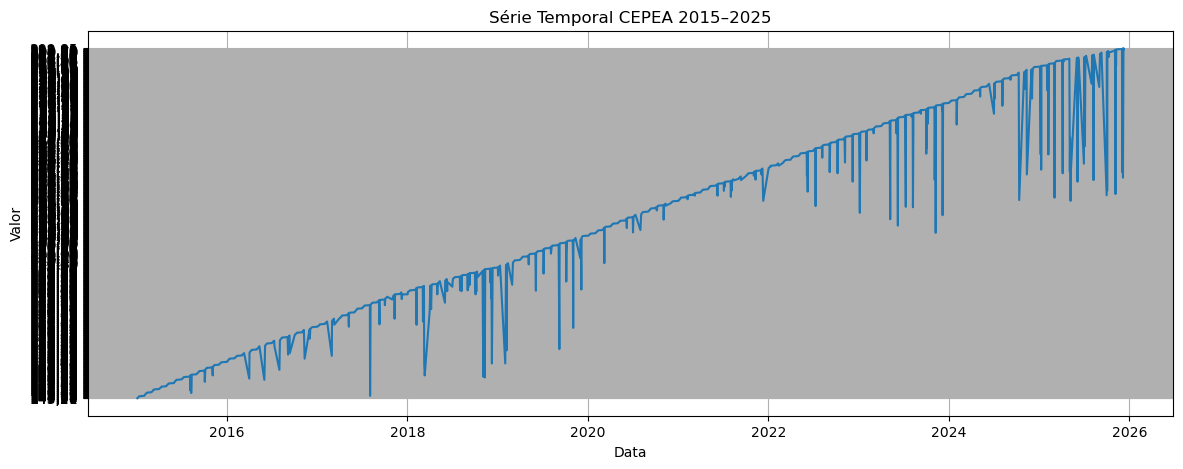

In [9]:
# ============================================
# 4. SÉRIE TEMPORAL
# ============================================

plt.figure(figsize=(14,5))
plt.plot(df["Data"], df["Valor"])
plt.title("Série Temporal CEPEA 2015–2025")
plt.xlabel("Data")
plt.ylabel("Valor")
plt.grid(True)
plt.show()


5. Gráfico de Média Móvel

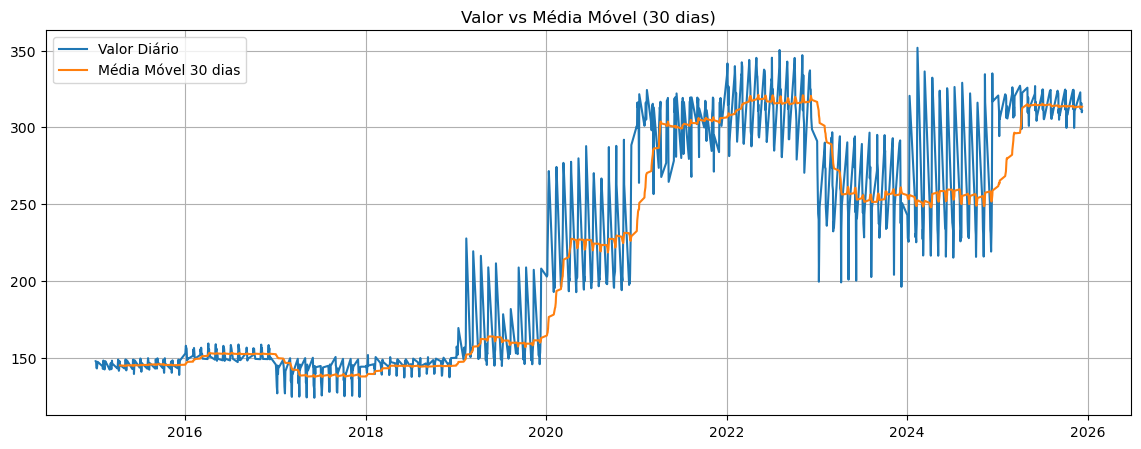

In [16]:
# ============================================
# 5. MÉDIA MÓVEL (TENDÊNCIA SUAVIZADA)
# ============================================

df["MM_30d"] = df["Valor"].rolling(window=30).mean()

plt.figure(figsize=(14,5))
plt.plot(df["Data"], df["Valor"], label="Valor Diário")
plt.plot(df["Data"], df["MM_30d"], label="Média Móvel 30 dias")
plt.legend()
plt.grid(True)
plt.title("Valor vs Média Móvel (30 dias)")
plt.show()


6. Decomposição da série temporal (tendência / sazonalidade / ruído)

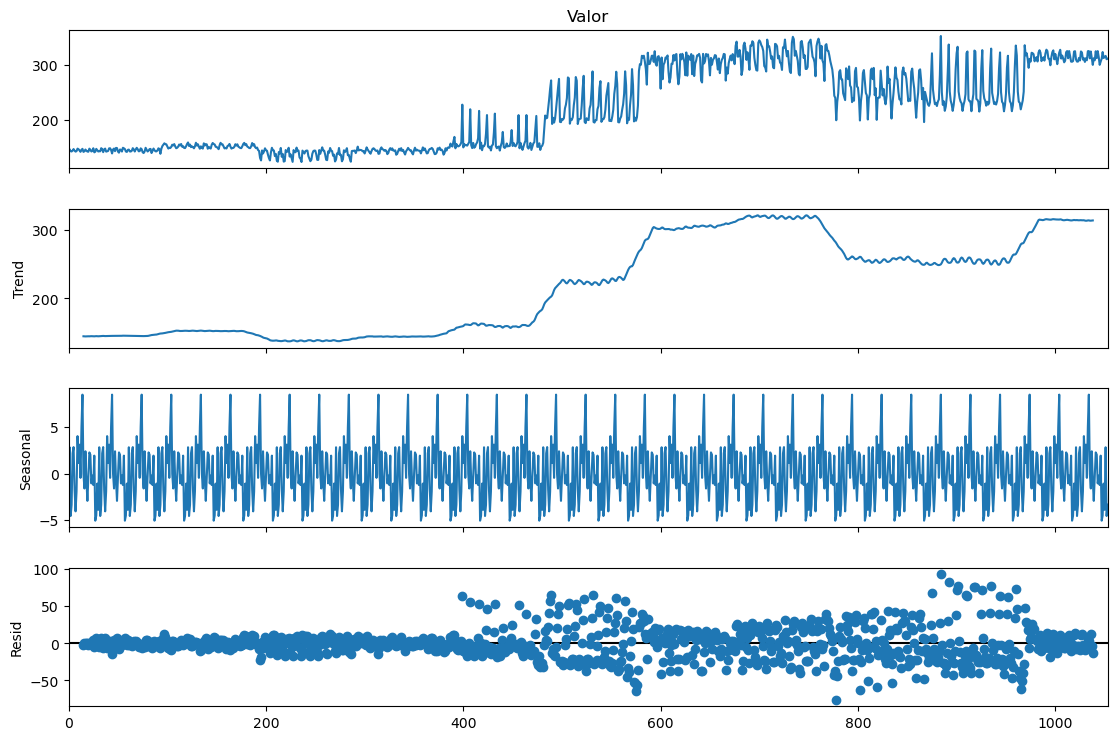

In [17]:
# ============================================
# 6. DECOMPOSIÇÃO DA SÉRIE TEMPORAL
# ============================================

from statsmodels.tsa.seasonal import seasonal_decompose

decomposicao = seasonal_decompose(df["Valor"], period=30, model="additive")

fig = decomposicao.plot()
fig.set_size_inches(12, 8)
plt.show()


7. Preparação dos dados para Modelos de Machine Learning

In [18]:
# ============================================
# 7. PREPARAÇÃO PARA MACHINE LEARNING
# ============================================

base_ml = df.copy()

# EXTRAINDO FEATURES DE DATA
base_ml["Ano"] = base_ml["Data"].dt.year
base_ml["Mes"] = base_ml["Data"].dt.month
base_ml["Dia"] = base_ml["Data"].dt.day
base_ml["DiaSemana"] = base_ml["Data"].dt.weekday

# LAG FEATURES (para aprender tendência)
base_ml["Lag_1"]  = base_ml["Valor"].shift(1)
base_ml["Lag_7"]  = base_ml["Valor"].shift(7)
base_ml["Lag_30"] = base_ml["Valor"].shift(30)

# Média móvel como feature
base_ml["MM_7"]  = base_ml["Valor"].rolling(7).mean()
base_ml["MM_30"] = base_ml["Valor"].rolling(30).mean()

# Remover linhas iniciais com valores nulos devido aos lags
base_ml = base_ml.dropna().reset_index(drop=True)

base_ml.head()


,Data,Valor,MM_30d,Ano,Mes,Dia,DiaSemana,Lag_1,Lag_7,Lag_30,MM_7,MM_30
0,2015-05-01,143.20,145.038667,2015,5,1,4,145.54,143.23,147.97,144.904286,145.038667
1,2015-05-02,143.66,144.920667,2015,5,2,5,143.20,144.12,147.20,144.838571,144.920667
2,2015-05-03,143.57,144.916000,2015,5,3,6,143.66,149.04,143.71,144.057143,144.916000
3,2015-05-05,149.13,145.112333,2015,5,5,1,143.57,141.72,143.24,145.115714,145.112333
4,2015-05-06,147.59,145.205667,2015,5,6,2,149.13,142.79,144.79,145.801429,145.205667


8. Separação em treino e teste

In [19]:
# ============================================
# 8. SEPARAÇÃO TREINO/TESTE
# ============================================

from sklearn.model_selection import train_test_split

X = base_ml.drop(columns=["Valor", "Data"])
y = base_ml["Valor"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=False
)

X_train.shape, X_test.shape


((870, 10), (154, 10))